In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense, LSTM
from keras.models import Sequential


In [2]:
df = pd.read_csv('online_retail_rfmscore.csv')
df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,revenue,score,segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,1,Low-Value
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Low-Value
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,1,Low-Value
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Low-Value
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Low-Value


In [3]:
df.shape

(406829, 11)

In [4]:
df.isnull().sum()

invoiceno      0
stockcode      0
description    0
quantity       0
invoicedate    0
unitprice      0
customerid     0
country        0
revenue        0
score          0
segment        0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    406829 non-null  object 
 1   stockcode    406829 non-null  object 
 2   description  406829 non-null  object 
 3   quantity     406829 non-null  int64  
 4   invoicedate  406829 non-null  object 
 5   unitprice    406829 non-null  float64
 6   customerid   406829 non-null  float64
 7   country      406829 non-null  object 
 8   revenue      406829 non-null  float64
 9   score        406829 non-null  int64  
 10  segment      406829 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 34.1+ MB


In [6]:
sales = df.groupby('invoicedate')['revenue'].sum().reset_index()

In [7]:
sales['invoicedate'] = pd.to_datetime(sales.invoicedate)

In [8]:
sales.dtypes

invoicedate    datetime64[ns]
revenue               float64
dtype: object

In [9]:
sales.rename(columns={'invoicedate': 'date', 'revenue': 'sale'}, inplace=True)

In [10]:
year = sales['date'].dt.year.astype('str')
month = sales['date'].dt.month.astype('str')
week = sales['date'].dt.week.astype('str')

sales['date'] = year + '-' + month + '-' + week

In [11]:
sales.head()

,date,sale
0,2010-12-48,139.12
1,2010-12-48,22.20
2,2010-12-48,348.78
3,2010-12-48,17.85
4,2010-12-48,855.86


In [12]:
df_sale = sales.groupby('date').sale.sum().reset_index()

In [13]:
df_sale.shape

(63, 2)

In [14]:
df_sale.date.max()

'2011-9-39'

In [15]:
df_sale.date.min()

'2010-12-48'

In [16]:
df_sale.shape

(63, 2)

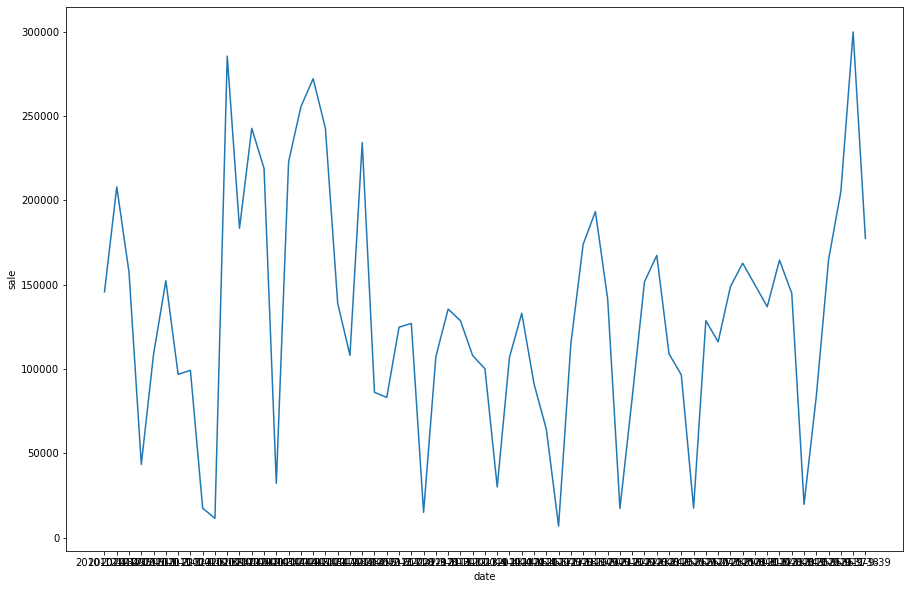

In [17]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='sale', data=df_sale)

In [18]:
sales_diff = df_sale.copy()

sales_diff['previous_sale'] = sales_diff['sale'].shift(1)

In [19]:
sales_diff = sales_diff.dropna()

sales_diff['diff'] = (sales_diff.sale - sales_diff.previous_sale)

In [20]:
sales_diff

,date,sale,previous_sale,diff
1,2010-12-49,208040.570,145805.750,62234.820
2,2010-12-50,157227.370,208040.570,-50813.200
3,2010-12-51,43530.330,157227.370,-113697.040
4,2011-1-1,108968.860,43530.330,65438.530
5,2011-1-2,152375.610,108968.860,43406.750
...,...,...,...,...
58,2011-9-35,83920.630,19886.970,64033.660
59,2011-9-36,164930.550,83920.630,81009.920
60,2011-9-37,205208.970,164930.550,40278.420
61,2011-9-38,299886.361,205208.970,94677.391


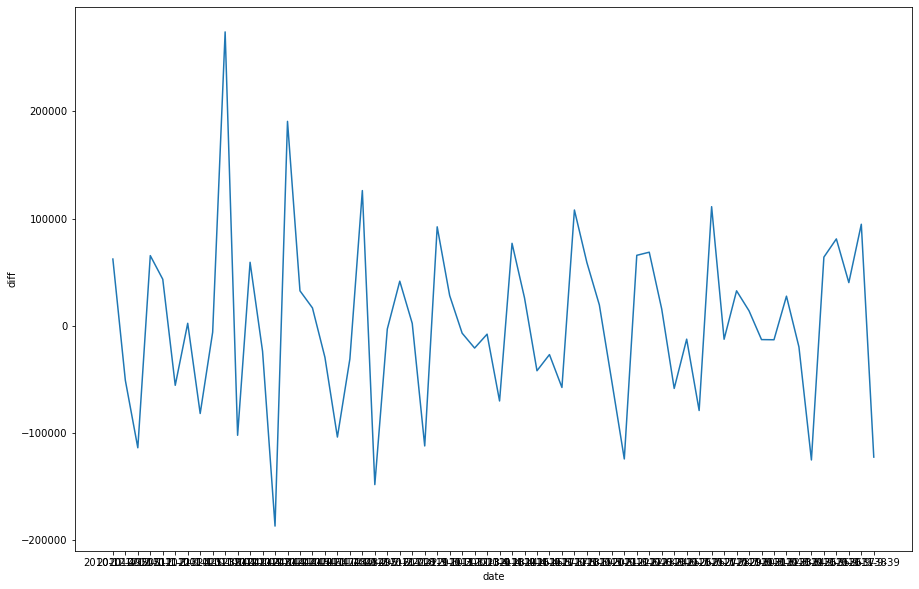

In [21]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='diff', data=sales_diff)

In [22]:
sales_diff

,date,sale,previous_sale,diff
1,2010-12-49,208040.570,145805.750,62234.820
2,2010-12-50,157227.370,208040.570,-50813.200
3,2010-12-51,43530.330,157227.370,-113697.040
4,2011-1-1,108968.860,43530.330,65438.530
5,2011-1-2,152375.610,108968.860,43406.750
...,...,...,...,...
58,2011-9-35,83920.630,19886.970,64033.660
59,2011-9-36,164930.550,83920.630,81009.920
60,2011-9-37,205208.970,164930.550,40278.420
61,2011-9-38,299886.361,205208.970,94677.391


In [23]:
df_supervised = sales_diff.drop(['previous_sale'],axis=1)
for inc in range(1,7):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [24]:
df_supervised.head()

,date,sale,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,2011-1-4,99270.78,2354.02,-55458.85,43406.75,65438.53,-113697.04,-50813.20,62234.82
1,2011-1-5,17542.37,-81728.41,2354.02,-55458.85,43406.75,65438.53,-113697.04,-50813.20
2,2011-10-39,11572.00,-5970.37,-81728.41,2354.02,-55458.85,43406.75,65438.53,-113697.04
3,2011-10-40,285549.58,273977.58,-5970.37,-81728.41,2354.02,-55458.85,43406.75,65438.53
4,2011-10-41,183502.98,-102046.60,273977.58,-5970.37,-81728.41,2354.02,-55458.85,43406.75


In [25]:
df_supervised.shape

(56, 9)

In [26]:
import statsmodels.formula.api as smf

In [27]:
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)

model_fit = model.fit()

reg_adj_rsq = model_fit.rsquared_adj

In [28]:
reg_adj_rsq

0.051282091132656915

In [29]:
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.3605388471695241


In [30]:
data = df_supervised.drop(['sale', 'date'], axis=1)

In [31]:
data.head()

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,2354.02,-55458.85,43406.75,65438.53,-113697.04,-50813.20,62234.82
1,-81728.41,2354.02,-55458.85,43406.75,65438.53,-113697.04,-50813.20
2,-5970.37,-81728.41,2354.02,-55458.85,43406.75,65438.53,-113697.04
3,273977.58,-5970.37,-81728.41,2354.02,-55458.85,43406.75,65438.53
4,-102046.60,273977.58,-5970.37,-81728.41,2354.02,-55458.85,43406.75


In [32]:
train_set = data[0:-10].values

In [33]:
test_set = data[-10:].values

In [34]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_set_scaled = scaler.fit_transform(train_set)

In [35]:
train_set_scaled[:5]

array([[-0.17925163, -0.43024576, -0.00102151,  0.0946293 , -0.68308642,
        -0.41007671,  0.08072041],
       [-0.54429486, -0.17925163, -0.43024576, -0.00102151,  0.0946293 ,
        -0.68308642, -0.41007671],
       [-0.2153919 , -0.54429486, -0.17925163, -0.43024576, -0.00102151,
         0.0946293 , -0.68308642],
       [ 1.        , -0.2153919 , -0.54429486, -0.17925163, -0.43024576,
        -0.00102151,  0.0946293 ],
       [-0.63250613,  1.        , -0.2153919 , -0.54429486, -0.17925163,
        -0.43024576, -0.00102151]])

In [36]:
test_set_scaled = scaler.transform(test_set)

In [37]:
test_set_scaled[:5]

array([[-0.24524457, -0.12881021, -0.04779966, -0.24381413,  0.29269126,
        -0.5322127 , -0.2434791 ],
       [-0.24588212, -0.24524457, -0.12881021, -0.04779966, -0.24381413,
         0.29269126, -0.5322127 ],
       [-0.06948159, -0.24588212, -0.24524457, -0.12881021, -0.04779966,
        -0.24381413,  0.29269126],
       [-0.27486301, -0.06948159, -0.24588212, -0.24524457, -0.12881021,
        -0.04779966, -0.24381413],
       [-0.73238572, -0.27486301, -0.06948159, -0.24588212, -0.24524457,
        -0.12881021, -0.04779966]])

In [38]:
train_set_scaled.shape

(46, 7)

In [39]:
X_train, y_train = train_set_scaled[:,1:], train_set_scaled[:,0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [40]:
X_test, y_test = test_set_scaled[:,1:], test_set_scaled[:,0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [41]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
          
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, validation_split=0.2)

Epoch 1/100
36/36 [==============================] - 1s 17ms/step - loss: 0.1662 - val_loss: 0.0680
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.1612 - val_loss: 0.0636
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1576 - val_loss: 0.0609
Epoch 4/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1546 - val_loss: 0.0590
Epoch 5/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1519 - val_loss: 0.0576
Epoch 6/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1493 - val_loss: 0.0564
Epoch 7/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1468 - val_loss: 0.0553
Epoch 8/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1444 - val_loss: 0.0543
Epoch 9/100
36/36 [==============================] - 0s 5ms/step - loss: 0.1421 - val_loss: 0.0533
Epoch 10/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1399 - val_loss: 0.0524
Epoch 11

36/36 [==============================] - 0s 6ms/step - loss: 0.0648 - val_loss: 0.0281
Epoch 84/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0643 - val_loss: 0.0282
Epoch 85/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0639 - val_loss: 0.0283
Epoch 86/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0634 - val_loss: 0.0285
Epoch 87/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0630 - val_loss: 0.0286
Epoch 88/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0625 - val_loss: 0.0287
Epoch 89/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0621 - val_loss: 0.0289
Epoch 90/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0616 - val_loss: 0.0290
Epoch 91/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0612 - val_loss: 0.0292
Epoch 92/100
36/36 [==============================] - 0s 5ms/step - loss: 0.0607 - val_loss: 0.0294
Epoch 93/100


In [42]:
model.save_weights('Sale_weights.h5')
print('Saved model to disk')

Saved model to disk


In [43]:
zmodel = Sequential()
zmodel.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
zmodel.add(Dense(1))
zmodel.load_weights('Sale_weights.h5')
print('Weights loaded')

Weights loaded


In [44]:
zmodel.compile(loss='mean_squared_error', optimizer='adam')
zmodel.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1, shuffle=False, validation_split=0.2)

Epoch 1/50
36/36 [==============================] - 1s 17ms/step - loss: 0.0594 - val_loss: 0.0314
Epoch 2/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0568 - val_loss: 0.0311
Epoch 3/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0559 - val_loss: 0.0316
Epoch 4/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0555 - val_loss: 0.0319
Epoch 5/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0552 - val_loss: 0.0320
Epoch 6/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0548 - val_loss: 0.0322
Epoch 7/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0544 - val_loss: 0.0324
Epoch 8/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0540 - val_loss: 0.0327
Epoch 9/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0536 - val_loss: 0.0329
Epoch 10/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0532 - val_loss: 0.0332
Epoch 11/50
36/36 

In [45]:
score = zmodel.evaluate(X_train, y_train)

2/2 [==============================] - 0s 5ms/step - loss: 0.1960


In [46]:
score_test = zmodel.evaluate(X_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.2562


In [47]:
y_pred = zmodel.predict(X_test, batch_size=1)

In [48]:
y_pred

array([[-0.7092314 ],
       [-0.4942394 ],
       [ 0.03264166],
       [-0.1737963 ],
       [-0.11195481],
       [ 0.15071931],
       [ 0.09665769],
       [-0.44802096],
       [-0.40190142],
       [-0.58229   ]], dtype=float32)

In [49]:
y_pred.sum()

-2.6414156

In [50]:
y_test

array([[-0.24524457],
       [-0.24588212],
       [-0.06948159],
       [-0.27486301],
       [-0.73238572],
       [ 0.08853006],
       [ 0.16223237],
       [-0.01460313],
       [ 0.22156959],
       [-0.7208377 ]])

In [51]:
y_test.sum()

-1.830965816217509

In [52]:
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [53]:
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))  

[[-0.70923138 -0.12881021 -0.04779966 -0.24381413  0.29269126 -0.5322127
  -0.2434791 ]]
[[-0.49423939 -0.24524457 -0.12881021 -0.04779966 -0.24381413  0.29269126
  -0.5322127 ]]
[[ 0.03264166 -0.24588212 -0.24524457 -0.12881021 -0.04779966 -0.24381413
   0.29269126]]
[[-0.1737963  -0.06948159 -0.24588212 -0.24524457 -0.12881021 -0.04779966
  -0.24381413]]
[[-0.11195481 -0.27486301 -0.06948159 -0.24588212 -0.24524457 -0.12881021
  -0.04779966]]
[[ 0.15071931 -0.73238572 -0.27486301 -0.06948159 -0.24588212 -0.24524457
  -0.12881021]]
[[ 0.09665769  0.08853006 -0.73238572 -0.27486301 -0.06948159 -0.24588212
  -0.24524457]]
[[-0.44802096  0.16223237  0.08853006 -0.73238572 -0.27486301 -0.06948159
  -0.24588212]]
[[-0.40190142 -0.01460313  0.16223237  0.08853006 -0.73238572 -0.27486301
  -0.06948159]]
[[-0.58228999  0.22156959 -0.01460313  0.16223237  0.08853006 -0.73238572
  -0.27486301]]


In [54]:
pred_test_set[0]

array([[-0.70923138, -0.12881021, -0.04779966, -0.24381413,  0.29269126,
        -0.5322127 , -0.2434791 ]])

In [55]:
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [56]:
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [57]:
result_list = []
sales_dates = list(sales_diff[-10:].date)
act_sales = list(sales_diff[-10:].sale)

for index in range(0, len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [58]:
df_result

,pred_value,date
0,30244,2011-8-31
1,66771,2011-8-32
2,215768,2011-8-33
3,148549,2011-8-34
4,37741,2011-8-35
5,162278,2011-9-35
6,230836,2011-9-36
7,145655,2011-9-37
8,250956,2011-9-38
9,87013,2011-9-39


In [59]:
sales_diff.tail(10)

,date,sale,previous_sale,diff
53,2011-8-31,149963.460,162809.961,-12846.501
54,2011-8-32,136970.110,149963.460,-12993.350
55,2011-8-33,164608.070,136970.110,27637.960
56,2011-8-34,144939.390,164608.070,-19668.680
57,2011-8-35,19886.970,144939.390,-125052.420
58,2011-9-35,83920.630,19886.970,64033.660
59,2011-9-36,164930.550,83920.630,81009.920
60,2011-9-37,205208.970,164930.550,40278.420
61,2011-9-38,299886.361,205208.970,94677.391
62,2011-9-39,177493.861,299886.361,-122392.500


In [60]:
df_sales_pred = pd.merge(sales_diff, df_result, on='date', how='left')

In [61]:
df_sales_pred

,date,sale,previous_sale,diff,pred_value
0,2010-12-49,208040.570,145805.750,62234.820,NaN
1,2010-12-50,157227.370,208040.570,-50813.200,NaN
2,2010-12-51,43530.330,157227.370,-113697.040,NaN
3,2011-1-1,108968.860,43530.330,65438.530,NaN
4,2011-1-2,152375.610,108968.860,43406.750,NaN
...,...,...,...,...,...
57,2011-9-35,83920.630,19886.970,64033.660,162278.0
58,2011-9-36,164930.550,83920.630,81009.920,230836.0
59,2011-9-37,205208.970,164930.550,40278.420,145655.0
60,2011-9-38,299886.361,205208.970,94677.391,250956.0


In [66]:
actual = df_sales_pred.sale[-10:].sum()
predicted = df_sales_pred.pred_value[-10:].sum()
actual - predicted

171997.37199999997

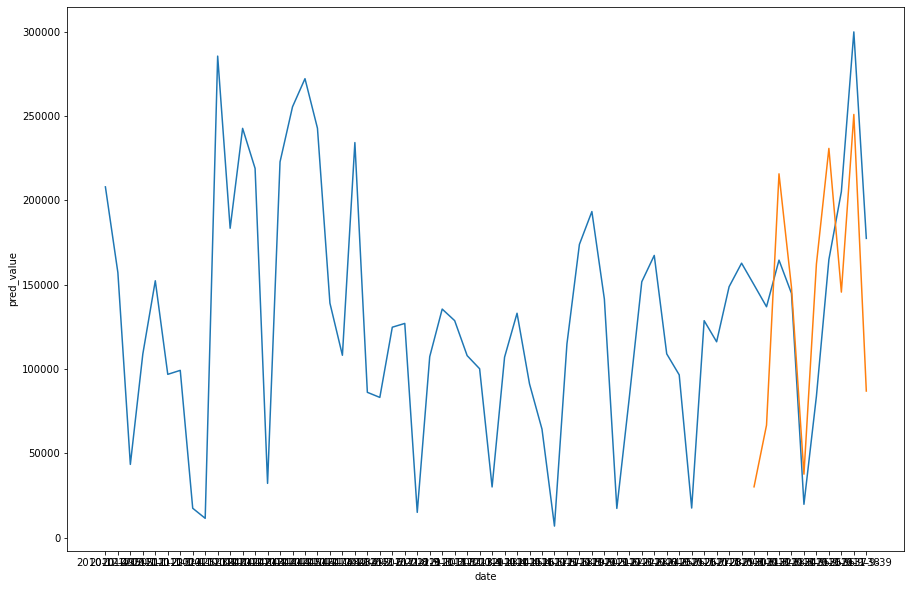

In [62]:
plt.figure(figsize=(15,10))
sns.lineplot(x='date', y='sale', data=df_sales_pred)
sns.lineplot(x='date', y='pred_value', data=df_sales_pred)